# Optimized Neural Networks with Tensorflow
<p class='lead'>
Author: Oliveira, Markos F. B. G.<br />
</p>

# Description

This document is based on Chapter 11 content of Geron's book *Hands-On Machine Learning with Scikit-Learn & TensorFlow*. It covers only the basics of the related topics and it's not meant to be a tutorial. Please, refer to the referenced book and scikit-learn/tensorflow online documentation for specific information.

In paticular, this notebook provides an example of applying neural networks using Tensorflow on MNIST classification data.

The algorithm that minimizes the cost function is a plain stochastic gradient descent with mean squared error. An automatic search for good hyperparameters is not implemented, nor ensemble methods are used. However, it employs a naive implementation of early stopping.

In [3]:
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import numpy as np
from datetime import datetime
import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the dataset

From TF dataset repository it's possible to load MNIST data. From the average values of mean and standard deviation it's probable that the digits in the test and validation sets came from same distribution of the training set. It would be possible to check if there are differences in the distributions of the digits between the datasets.

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz

Training data shape: inputs  (55000, 784) outputs (55000,)
Validation data shape: inputs  (5000, 784) outputs (5000,)
Test data shape: inputs  (10000, 784) outputs (10000,)

Average value of the mean of all 784 features in training set: 0.130702
Average value of the mean of all 784 features in validation set: 0.130223
Average value of the mean of all 784 features in test set: 0.132516
Average value of the standard deviation of all 784 features in training set: 0.193211
Average value of the standard deviation of all 784 features in validation set: 0.192845
Average value of the standard deviation of all 784 features in test set: 0.192418


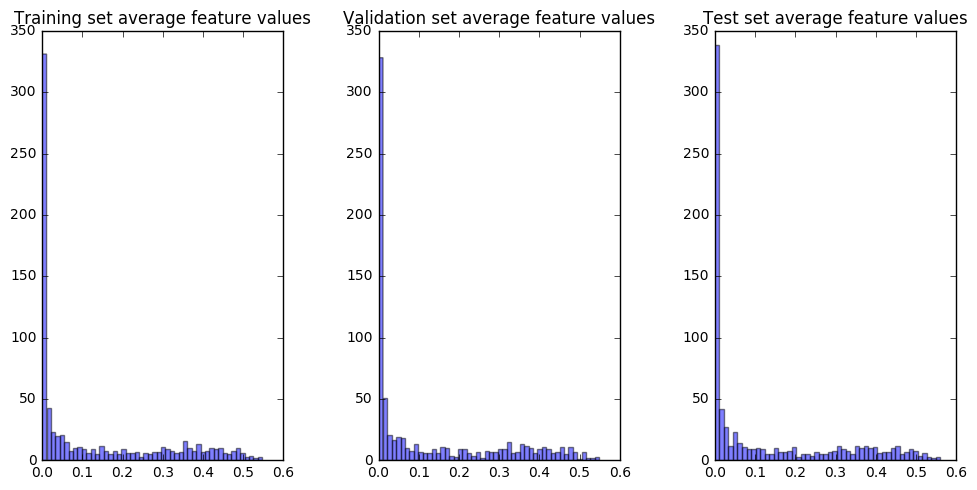

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

#Downloading and extracting the data
mnist = input_data.read_data_sets("/tmp/data/")

#Fetching the data
X_train = mnist.train.images
X_val = mnist.validation.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_val = mnist.validation.labels.astype("int")
y_test = mnist.test.labels.astype("int")

#Changing the outputs to 2d-arrays:
#y_train = y_train.reshape(-1, 1)
#y_val = y_val.reshape(-1, 1)
#y_test = y_test.reshape(-1, 1)
print('\nTraining data shape: inputs ', X_train.shape, 'outputs', y_train.shape)
print('Validation data shape: inputs ', X_val.shape, 'outputs', y_val.shape)
print('Test data shape: inputs ', X_test.shape, 'outputs', y_test.shape)

#Prining mean/std info
print('\nAverage value of the mean of all 784 features in training set:', np.mean(X_train.mean(axis=0)))
print('Average value of the mean of all 784 features in validation set:', np.mean(X_val.mean(axis=0)))
print('Average value of the mean of all 784 features in test set:', np.mean(X_test.mean(axis=0)))
print('Average value of the standard deviation of all 784 features in training set:', np.mean(X_train.std(axis=0)))
print('Average value of the standard deviation of all 784 features in validation set:', np.mean(X_val.std(axis=0)))
print('Average value of the standard deviation of all 784 features in test set:', np.mean(X_test.std(axis=0)))

#Plotting the histograms of the mean feature values
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
ax = axes.ravel()
ax[0].hist(X_train.mean(axis=0), bins=50, color='b', alpha=.5)
ax[0].set_title('Training set average feature values')
ax[1].hist(X_val.mean(axis=0), bins=50, color='b', alpha=.5)
ax[1].set_title('Validation set average feature values')
ax[2].hist(X_test.mean(axis=0), bins=50, color='b', alpha=.5)
ax[2].set_title('Test set average feature values')
fig.tight_layout()

It's possible to see that the data is already normalized, all features have maximum value one and minimum value zero (minmax normalization). Some pixels have only zero values, such as pixel 0.
In general, we apply the normalization in different datasets from info gained only in training set. In the case of minmax normalization, it's necessary to calculate the maximum and the minimum values (taken from training data). The training, validation and test datasets are then normalized, where each entry $x$ is updated to $x = \frac{x-min(f_x)}{max(f_x)-min(f_x)}$, where $f_x$ is the feature where x entry belongs. Because the *min* and *max* values are taken from the training data, after this normalization its minimum and maximum value naturally becomes 0 and 1 respectively. However, applying this same values to the validaiton and test sets, their min and max values probably are not 0 and 1 after normalization.

It can be seen however, that all sets have same min and max values of a pixel, which is strange. It's possible that these datasets were normalized independently, which according to Muller's book it's an improperly way to scale data (in page 135(pdf) it's presented an example).

In [5]:
print('Max and min values of pixel 0 in training set: {}/{}'.format(np.max(X_train[:,0]), np.min(X_train[:,0])))
print('Max and min values of a feature/pixel in training set: {}/{}'.format(np.max(X_train[:,300]), np.min(X_train[:,300])))
print('Max and min values of a feature/pixel in the validation set: {}/{}'.format(np.max(X_val[:,300]), np.min(X_val[:,300])))
print('Max and min values of a feature/pixel in the test set: {}/{}'.format(np.max(X_test[:,300]), np.min(X_test[:,300])))

Max and min values of pixel 0 in training set: 0.0/0.0
Max and min values of a feature/pixel in training set: 1.0/0.0
Max and min values of a feature/pixel in the validation set: 1.0/0.0
Max and min values of a feature/pixel in the test set: 1.0/0.0


It's possible to train a neural network with training set and validation set together, even though it's common to have a validaiton set to perform early-stopping or to search for good hyperparameters, for example. It's not allowed however, mainly in this case where we have a standard database, to train including the test set. In a case where we need to implement a model in a real-world scenario though, we could include the test set, after its use in the evaluation.

In [6]:
train_plus_val = False
if train_plus_val:
    X_train = np.concatenate((X_train, X_val), axis=0)
    y_train = np.concatenate((y_train, y_val), axis=0)

#Storing some important values
n_inputs = X_train.shape[1]
n_outputs = (np.unique(y_train)).size
m = X_train.shape[0]
print('Inputs shape of training data: ', X_train.shape)
print('Outputs shape of training data: ', y_train.shape)
print('# inputs: ', n_inputs) # 28*28 = MNIST
print('# outputs: ', n_outputs)
print('# instances: ', m)

Inputs shape of training data:  (55000, 784)
Outputs shape of training data:  (55000,)
# inputs:  784
# outputs:  10
# instances:  55000


### Mini-batch creation function

In stochastic gradient descent it's necessary to provide stochastic small batches of examples so that the algorithm updates more often and eventually converges faster. The function returns a mini-batch when its called using two approaches.

- In the 1st approach random indices from dataset are selected to be inside the mini-batch using a randomized seed, which is the number of the training iteration (epoch*n_batches + batch_index). In this case, one epoch does not pass through all the different examples.
- In the 2nd approach a random permutation of the examples is passed and a slice of this permutation is used as mini-batch. In this case all the examples are used in one epoch, thus it's a better approach. A random permutation of the examples is necessary to be computed once per epoch oustide the iteration over the batches.

In [7]:
def fetch_batch(epoch, batch_index, batch_size, idxs, Xs, ys, approach=2):
    """Returns the mini-batch (X, y) for a training step.

    Parameters
    ----------
    epoch : int
        Number of epoch.
    batch_index : int
        Number of batch inside the epoch.
    batch_size : int
        Batch size.
    idxs : list of int
        Permutation of training set indices.
    approach: int, optional
        Approach used for chosing the mini-batches. 
    Returns
    -------
    X_batch : np.ndarray
        Mini-batch of inputs.
    y_batch : np.ndarray
        Mini-batch of outputs.
    """
    
    if approach == 1:
        # 1st approach: in this approach random indices from dataset are selected to be inside the mini-batch using a
        #randomized seed, which is the number of the training iteration. In this case, one epoch probably does
        #not have all the different examples.
        rnd.seed(epoch * n_batches + batch_index)
        indices = rnd.randint(m, size=batch_size)
    elif approach == 2:
        # 2nd approach: in this approach a random permutation of the examples is passed and a slice of this permutation
        #is used as mini-batch.
        indices = idxs[batch_index * batch_size: (batch_index + 1) * batch_size]
    
    X_batch = Xs[indices]
    y_batch = ys[indices]
    
    return X_batch, y_batch

### Neural networks layer creation function

It's good to have a function that manually creates the archictecure of a neural network. In this way, it's possible to create structures that are not fully connected. Below, it's implemented a function that creates a canonical feedforward network. The function creates each layer at a time, and not the fully structure. The weights are initialized using common method found in literature to speed up convergence and avoid saturation in early stages of learning.

In [8]:
def neuron_layer(X, n_neurons, name, activation=None):
    """Manually creates the layers of the neural network.

    Parameters
    ----------
    X : np.ndarray
        Input values of the layer (m_batch, n_inputs).
    n_neurons : int
        Number of neurons in the layer.
    name : string
        Scope name of the layer.
    activation : string
        Type of activation function.
    Returns
    -------
    z : np.ndarray
        The output of the layer.
    """
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs) # good strategy to initialize the NN's weights.
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev, seed = 0) # using truncated distribution we avoid
        #values whose magnitude is more than 2 standard deviations (95%) from the mean, which is zero (these values are
        #dropped and re-picked). It helps with convergence speed.
        W = tf.Variable(init, name="weights")
        b = tf.Variable(tf.zeros([n_neurons]), name="biases")
        z = tf.matmul(X, W) + b #If m_match > 1 tf.matmul(X, W) is a matrix; b i summed to all of its columns.
        
        if activation=="relu":
            return tf.nn.relu(z)
        elif activation=="sigmoid":
            return tf.nn.sigmoid
        elif activation=="tanh":
            return tf.nn.tanh
        else:
            return z

### Neural networks training

Below, some of the paramters related to training can be set.

In [9]:
#SGD parameters:
n_epochs = 500
learning_rate = 0.01
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

#Early-stopping:
early_stopping = True #enable early stopping.
early_stopping_step = 1 #steps in the number of epochs stopping must be checked.
min_val_error = float("inf") #stores the best error so far.
min_val_error_epoch = 0 #epoch when minimum validation error was found.
n_it = 2*batch_size #maximum number of iterations without improvement in validation error.
imp_counter = 0 #counts the umber of iterations there is no improvement in the validation error.
stop_learning = False #enable stop learning after 'n_it' iterations of no improvement in validation error. If 'False', all
#epochs are runned, but the model which least validation error is returned.

#Monitoring:
prt = True # enable printing training statistics.
print_step = 100 # number of epochs to periodically print training statistics.

#Logging:
log = True # enable logging accuracy values.
log_step = 1
val_error_list = []
train_error_list = []
test_error_list = []

#Neural networks layers:
manual_layers = True #manually creates the layers using 'neural_layer' function.
tf_batch = fetch_batch # use implemented TF function to load mini-batches.
#for MNIST: tf_batch = mnist.train.next_batch(batch_size)
n_hidden1 = 300
n_hidden2 = 100
#Obs.: the archictecture of the layer must be constructed inside the 'CONSTRUCTION PHASE' of the nn graph.

#Save/restore:
restore = False # restore old model
save_ckpt = False # save chackpoints
saver_step = 100 # number of epochs to periodically save model's checkpoint.
path_restore = '/tmp/finals/my_model_final.ckpt'

#Tensorboard:
tb = False # log training statistics for tensorboard.
root_logdir = "tf_logs"
tensorboard_step = 100 # number of epochs to periodically log statistics in tensorboard log files.

### Weights initialization, activation functions and batch-normalization

It's important to emphasize the parameters of the main funciton used in this code, tf.layers.dense():

dense(inputs,
    units,
    activation=None,
    use_bias=True,
    kernel_initializer=None,
    bias_initializer=tf.zeros_initializer(),
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    trainable=True,
    name=None,
    reuse=None)
        
    inputs: Tensor input.
    units: Integer or Long, dimensionality of the output space.
    activation: Activation function (callable). Set it to None to maintain a linear activation.
    use_bias: Boolean, whether the layer uses a bias.
    kernel_initializer: Initializer function for the weight matrix.
    bias_initializer: Initializer function for the bias.
    kernel_regularizer: Regularizer function for the weight matrix.
    bias_regularizer: Regularizer function for the bias.
    activity_regularizer: Regularizer function for the output.
    trainable: Boolean, if True also add variables to the graph collection GraphKeys.TRAINABLE_VARIABLES (see tf.Variable).
    name: String, the name of the layer.
    reuse: Boolean, whether to reuse the weights of a previous layer by the same name.
    
Some remarkable notes are needed:

* By changing the activation function of a layer, the best initialization strategy also changes; below we have some good initialization strategies for the most common functions.

        * Sigmoid: Xavier initialization
        Implementation:
        #Using tf.contrib:
        >> xavier_init = tf.contrib.layers.xavier_initializer()
        >> kernel_initializer = xavier_init
        #Using manual code: (TF uses the uniform code below as xavier initialization)
        >> low = -np.sqrt(6.0/(fan_in + fan_out)) # use 4 for sigmoid, 1 for tanh activation 
        >> high = np.sqrt(6.0/(fan_in + fan_out))
        >> init = tf.random_uniform(shape=(n_inputs, n_neurons), minval=low, maxval=high, dtype=tf.float32, seed=0)
        #or
        >> stddev = np.sqrt(2.0/(fan_in + fan_out))
        >> init = tf.truncated_normal(shape=(n_inputs, n_neurons), stddev=stddev, mean=0, dtype=tf.float32, seed=0)
        
        * Hyperbolic tangent
        Implementation:
        #Using manual code:
        >> low = -4*np.sqrt(6.0/(fan_in + fan_out)) # use 4 for sigmoid, 1 for tanh activation 
        >> high = 4*np.sqrt(6.0/(fan_in + fan_out))
        >> init = tf.random_uniform(shape=(n_inputs, n_neurons), minval=low, maxval=high, dtype=tf.float32, seed=0)
        #or
        >> stddev = 4*np.sqrt(2.0/(fan_in + fan_out))
        >> init = tf.truncated_normal(shape=(n_inputs, n_neurons), stddev=stddev, mean=0, dtype=tf.float32, seed=0)
        
        * ReLu: He initialization
        Implementation:
        #Using tf.contrib:
        >> he_init = tf.contrib.layers.variance_scaling_initializer(mode="FAN_AVG") #to consider both fan_int and fan_out.
        >> kernel_initializer = he_init
        #Using manual code:
        >> low = -np.sqrt(2.0)*np.sqrt(6.0/(fan_in + fan_out)) # use 4 for sigmoid, 1 for tanh activation 
        >> high = np.sqrt(2.0)*np.sqrt(6.0/(fan_in + fan_out))
        >> init = tf.random_uniform(shape=(n_inputs, n_neurons), minval=low, maxval=high, dtype=tf.float32, seed=0)
        #or
        >> stddev = np.sqrt(2.0)*np.sqrt(2.0/(fan_in + fan_out))
        >> init = tf.truncated_normal(shape=(n_inputs, n_neurons), stddev=stddev, mean=0, dtype=tf.float32, seed=0)
        
* The ReLu function should be your primary choice of 'common' activation functions, it's faster to evaluate than sigmoids and hyp-tangent and does not saturatefor positive values. However, we may experience the *dying ReLUs* phenomena, wher most neurons are dead (output zero) and cannot back to life. To avoid this problem other ReLU activation variants exist:

        * Leaky Relu: lr = max(alpha*z, z) 
        Alpha controls the slope of the function for z < 0 and it's tipically set to 0.01. But a recent paper *Empirical Evaluation of Rectified Activations in Convolution Network* found that a bigger leaky parameters of 0.2 (or 0.18) is consistently better.
        Implementation:
        >> def leaky_relu_function(z, alpha=0.2, name=None)
        >>    return np.maximum(alpha*z, z, name=name)
        >> hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu_function)
        
        * Randomized Leaky Relu (RReLU): rlr = max(alpha*z, z), alpha is randomly chosen.
        - During training (for example, for each epoch) alpha is chosen randomly using a uniform distribution U(low, high), such as U(1/8, 1/3).
        - During testing we chose an alpha of a_test = (low+high)/2
        - RReLu act as a regularizer.
        Implementation (training):
        >> def random_leaky_relu_function(z, min, max, name=None)
        >> assert((min<1) and (max<1))
        >> alpha = tf.random_uniform(shape=(1, 1), minval=min, maxval=max, dtype=tf.float32, seed=0)
        >>    return np.maximum(alpha*z, z, name=name)
        >> hidden1 = tf.layers.dense(X, n_hidden1, activation=random_leaky_relu_function) 
        
        * Exponential Linear Unit (ELU): if z < 0: f = alpha*(exp(z) - 1); if z >= 0: f = z.
        - alpha controls where f approaches when z becomes -inf. It's usually set to one.
        - has faster convergence rate than any other relu variants, however it's slower to compute.
        Implementation:
        >> act = tf.nn.elu
        >> hidden1 = tf.layers.dense(X, n_hidden1, activation_fn=act) #alpha = 1
        #or
        >> def elu_function(z, alpha=1):
        >>    return np.where(z<0, alpha*(np.exp(z)-1), z)
        >> hidden1 = tf.layers.dense(X, n_hidden1, activation=elu_fuction)
        
* Trials order of the activation functions: ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic. If you're suffering from regularization problems, try RReLU; if evaluation should be fast use leaky ReLU instead of ELU. When using these ReLU variants, the initialization parameter should be He init.

* Vanishing/exploding gradients problem still can occur during training even with the recommended choices of initialization and activation functions. To avoid this we could use batch-normalization.
        * It makes the networks converge much faster.
        * It makes the net more robust to the weight initialization.
        * It makes possible to use larger learning rates.
        * It acts as a regularizer, reducing the need of other techniques.
        * It removes the need for normalizing the input data.
        * It's slower to evaluate.
        * The implementation of this technique is a bit complex, so it's passed to a new *Code* cell (read the comments to understand the batch-normalization implementation.

In [14]:
# Example of implementation of batch_normalization using TF:
from functools import partial
run_example = True
if run_example:
    tf.reset_default_graph()
    
    n_epochs = 20
    batch_size = 100
    n_inputs = 28 * 28  # MNIST
    n_hidden1 = 300
    n_hidden2 = 100
    n_outputs = 10
    learning_rate = 0.01
    
    #CONSTRUCTION PHASE
    
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    y = tf.placeholder(tf.int64, shape=(None), name="y")
    is_training = tf.placeholder(tf.bool, shape=(), name='is_training')  #This will be used to tell the
    #batch_norm() function whether it should use the current mini-batch’s mean and standard deviation
    #(during training) or the running averages that it keeps track of (during testing).

    with tf.name_scope("dnn"):
        he_init = tf.contrib.layers.variance_scaling_initializer() #he initialization.
        
        #'partial' makes a new version of a function with one or more arguments already filled in.
        my_batch_norm_layer = partial( 
                tf.layers.batch_normalization,
                training=is_training,
                momentum=0.9) #The algorithm uses exponential decay
                #to compute the running averages, which is why it requires the decay parameters. Given a new value
                #v, the running average vhat is updated through the equation vhat = vhat*decay + v*(1-decay). A good
                #decay value is typically close to 1 — for example, 0.9, 0.99, or 0.999 (you want more 9s for larger
                #datasets and smaller mini-batches: which means that the batch contributes less to the overall value).
                #In the code, decay is called 'momentum', that's not related to the momentum optimizer.
        
        my_dense_layer = partial(
                tf.layers.dense,
                kernel_initializer=he_init)
        
        hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
        bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
        hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
        bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
        logits_before_bn = my_dense_layer(bn2, n_outputs, activation=None, name="outputs")
        logits = my_batch_norm_layer(logits_before_bn)
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) #the update operations needed by batch
        #normalization are added to the UPDATE_OPS collection and you need to explicity run these operations during training.
        #This extra update makes the  tf.layers.batch_normalization function updates
        #the running averages right before it performs batch normalization during training.
        
    with tf.name_scope("loss"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

    with tf.name_scope("train"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    #EXECUTION PHASE
    
    n_epochs = 20
    batch_size = 200

    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs+1):
            for iteration in range(len(mnist.test.labels)//batch_size):
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                sess.run([training_op, extra_update_ops], feed_dict={is_training: True, X: X_batch, y: y_batch})
                #Note above that since we are using `tf.layers.batch_normalization()`, 
                #we need to explicitly run the extra update operations needed by batch normalization.
            acc_train = accuracy.eval(feed_dict={is_training: False, X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={is_training: False, X: mnist.test.images, y: mnist.test.labels})
            print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        #save_path = saver.save(sess, "my_model_final.ckpt")

0 Train accuracy: 0.73 Test accuracy: 0.7354
1 Train accuracy: 0.835 Test accuracy: 0.8128
2 Train accuracy: 0.79 Test accuracy: 0.8413
3 Train accuracy: 0.825 Test accuracy: 0.8582
4 Train accuracy: 0.81 Test accuracy: 0.8663
5 Train accuracy: 0.865 Test accuracy: 0.8743
6 Train accuracy: 0.85 Test accuracy: 0.8812
7 Train accuracy: 0.845 Test accuracy: 0.8869
8 Train accuracy: 0.89 Test accuracy: 0.8918
9 Train accuracy: 0.915 Test accuracy: 0.8947
10 Train accuracy: 0.93 Test accuracy: 0.8973
11 Train accuracy: 0.875 Test accuracy: 0.902
12 Train accuracy: 0.905 Test accuracy: 0.9053
13 Train accuracy: 0.865 Test accuracy: 0.9076
14 Train accuracy: 0.91 Test accuracy: 0.9092
15 Train accuracy: 0.955 Test accuracy: 0.9112
16 Train accuracy: 0.89 Test accuracy: 0.912
17 Train accuracy: 0.915 Test accuracy: 0.9163
18 Train accuracy: 0.885 Test accuracy: 0.9182
19 Train accuracy: 0.9 Test accuracy: 0.9181
20 Train accuracy: 0.885 Test accuracy: 0.9213


### Gradient Clipping

* Below there is a implementation of the gradient clipping procedure, where we limit the gradients to avoid explosive grad problem. Most used in RNN.

* optimizer.minimize() computes and also epply the gradients. For grad clipping, it's necessary to compute frist, apply yo the the gards the clipping and then apply.

* Gradient clipping is not used when batch normalization is applied.

In [15]:
if False: #never runs
    threshold = 1.0 #hyperparameter
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads_and_vars = optimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
    training_op = optimizer.apply_gradients(capped_gvs)

## State of the Art Implementation of Neural Networks

Effectively running the MNIST with optimized implementation using TF, including:
- Specialized weight initialization.
- Novel activation functions.
- Batch-normalization.
- Regularization.
- Efficient Optimizers

In [37]:
tf.reset_default_graph() #restoring the default graph.
tf.logging.set_verbosity(tf.logging.WARN) #supress TF logging messages when saving ckpt files.
start_time = time.time()
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir = "{}/run-{}/".format(root_logdir, now) #relative path of tensorboard logs for a particular run (current time
#is used so that each folder has different running stats, comparision between them can be made inside tensorboard).

# TF CONSTRUCTION PHASE

# 1- Creating variables, placeholders and constants.
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

# 2- Creating the operations.
with tf.name_scope("dnn"):
    if manual_layers:
        hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation="relu")
        hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu")
        logits = neuron_layer(hidden2, n_outputs, "output") # the final layer returns the logits only.
        softmax = tf.nn.softmax(logits, name="softmax")
    else:
        hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
        logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
        softmax = tf.nn.softmax(logits, name="softmax")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits) #this computes the cross entropy based 
    #directly on the logits of the output layer: it expects integer labels (from 0 to n_outputs-1). This returns the cross-entropy
    #scalar value for each instance.
    #Use 'softmax_cross_entropy_with_logits()' if the labels are in the form of one-hot vectors.
    loss = tf.reduce_mean(xentropy, name="loss") #computes the mean over the mini_batch.
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1) #returns boolean == True if the output y is in the first k highest probabilities.  
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) #computes the accuracy.

# 3- Node that initialize the variables.
init = tf.global_variables_initializer()

# 4- Creating the saver.
saver_save = tf.train.Saver(max_to_keep=None) #save all variable values.
if restore:
    saver_restore = tf.train.Saver() #restore all variable values.
    #saver_restore = tf.train.Saver({"weights": theta}) #restore only the old theta variable under the name of 'weights'.

# 5- Tensorboard definitions:
if tb:
    accuracy_summary = tf.summary.scalar('ACC', accuracy) # Creates a node in the graph that will evaluate the ACC value
    #and write it to a TensorBoard-compatible binary log string called a summary.
    summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph()) # Creates a FileWriter that you will
    #use to write summaries to logfiles in the log directory.

# TF EXECUTION PHASE:

with tf.Session() as sess:
    
    # To restore a model the construction phase must be identical than the one used to save it. 
    if restore:
        saver_restore.restore(sess, path_restore)
    else:
        sess.run(init) # Initializing the variables.
    
    breaker = False
    for epoch in range(n_epochs+1): # for each epoch..
        
        idXs = np.random.permutation(range(m))
        
        for batch_index in range(n_batches-1): # for each mini-batch..
            X_batch, y_batch = tf_batch(epoch, batch_index, batch_size, idXs, X_train, y_train)
            #Training step:
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        #Early-stopping (we could implement early stopping after each update (iteration), however, it would be too slow):
        if (early_stopping) and (epoch % early_stopping_step == 0):
            #val_error = loss.eval(feed_dict={X: X_val, y: y_val})
            val_error = 1 - accuracy.eval(feed_dict={X: X_val, y: y_val})
            imp_counter = imp_counter + 1 
            if val_error <= min_val_error:
                min_val_error = val_error
                min_val_error_epoch = epoch
                save_path = saver_save.save(sess, "./tmp/best_model-{}.ckpt".format(now))
                imp_counter = 0
            elif (stop_learning) and (imp_counter >= n_it):
                breaker = True
                break
        if breaker:
            break 
        
        if (log) and (epoch % log_step == 0):
            acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
            acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            val_error_list.append(acc_val)
            train_error_list.append(acc_train)
            test_error_list.append(acc_test)
        if (prt) and (epoch % print_step == 0):
            acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
            acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
            print("Epoch", epoch, "Training accuracy:", acc_train, "Validation accuracy:", acc_val)
        if (tb) and (epoch % tensorboard_step == 0):
            summary_str = accuracy_summary.eval(feed_dict={X: X_train, y: y_train}) # This will output a summary that
            #you can then write to the events file using the file_writer. Here is the updated code:
            step = epoch * n_batches + batch_index
            summary_writer.add_summary(summary_str, step)
        if (save_ckpt) and (epoch % saver_step == 0):
            save_path = saver_save.save(sess, "./tmp/my_model-{}.ckpt".format(epoch))
            
    if not (early_stopping):
        save_path = saver_save.save(sess, "./tmp/best_model-{}.ckpt".format(now))

# Flushing and closing FileWriter.          
if tb:                            
    summary_writer.flush()
    summary_writer.close() 

if early_stopping:
    print('Epoch {} with minimum validation error {:.4}.'.format(min_val_error_epoch, min_val_error))
best_model_path = "./tmp/best_model-{}.ckpt".format(now)
print("Best model saved as:", best_model_path)
print("Training time: %.8s seconds" % (time.time() - start_time)) 

Epoch 0 Training accuracy: 0.908033 Validation accuracy: 0.9216
Epoch 100 Training accuracy: 0.999883 Validation accuracy: 0.9998
Epoch 200 Training accuracy: 1.0 Validation accuracy: 1.0
Epoch 300 Training accuracy: 1.0 Validation accuracy: 1.0
Epoch 400 Training accuracy: 1.0 Validation accuracy: 1.0
Epoch 500 Training accuracy: 1.0 Validation accuracy: 1.0
Epoch 500 with minimum validation error 0.0.
Best model saved as: ./tmp/best_model-20170814205245.ckpt
Training time: 2603.517 seconds


#### Logged CPU/GPU times:
- NN with MNIST: 1185.27s (~19m)/
- NN with MNIST (early stopping): 2083.05s (~35m)/

### Using the neural network

In [38]:
saver_restore = tf.train.Saver() 
with tf.Session() as sess:
    saver_restore.restore(sess, best_model_path)
    X_test = mnist.test.images  # remember to transform this set if necessary.
    Z = logits.eval(feed_dict={X: X_test})
    y_prob = softmax.eval(feed_dict={X: X_test})
    y_pred = np.argmax(Z, axis=1) #or np.argmax(y_prob, axis=1)
    
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy in the test set of the best model found in the validation set: ', accuracy)

Accuracy in the test set of the best model found in the validation set:  0.9798


In the plot below it's possible to see the performance of the model. Note that one possible, and probably good criteria to stop learning is to monitor the traiing set accuracy. If it became too high (near 1.00, considering a tolerance) we can safely stop learning.

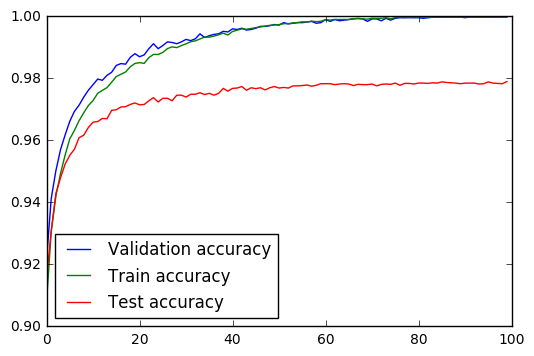

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(val_error_list[:100], label='Validation accuracy')
plt.plot(train_error_list[:100], label='Train accuracy')
plt.plot(test_error_list[:100], label='Test accuracy')
plt.legend(loc='best')
plt.show()

### Retraining the neural network

One approach to improve network performance it would be train using the training and validation sets until the epoch with best validation error. Experiments must be done to check the variance with respect to the knowledge obtained in the validation set, particularly the epoch.

Note that one must not use the test set to choose the least error, this is the purpose of the validation set only. Any choice made on the test set imediatly contaminates it, it looses its reliability of being a proxy of the generalization error.

It's not clear if we should renormalize the data after combining the training and validation sets.

In [20]:
X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

To trust in the result gained in the validation set, the network should be trained in the same way, with same parameters. For example, it's desirable to have the same initial weights of the first run. See however, that the mini-batches are unequal considering the 2nd approach.

In [21]:
tf.reset_default_graph() #restoring the default graph.
tf.logging.set_verbosity(tf.logging.WARN) #supress TF logging messages when saving ckpt files.
start_time = time.time()
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir = "{}/run-{}/".format(root_logdir, now) #relative path of tensorboard logs for a particular run (current time
#is used so that each folder has different running stats, comparision between them can be made inside tensorboard).

# TF CONSTRUCTION PHASE

# 1- Creating variables, placeholders and constants.
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

# 2- Creating the operations.
with tf.name_scope("dnn"):
    if manual_layers:
        hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation="relu")
        hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu")
        logits = neuron_layer(hidden2, n_outputs, "output") # the final layer returns the logits only.
        softmax = tf.nn.softmax(logits, name="softmax")
    else:
        hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
        logits = tf.layers.dense(hidden2, n_outputs, name="outputs") #Default 'activation' == None
        softmax = tf.nn.softmax(logits, name="softmax")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits) #this computes the cross entropy based 
    #directly on the logits of the output layer: it expects integer labels (from 0 to n_outputs-1). This returns the cross-entropy
    #scalar value for each instance.
    #Use 'softmax_cross_entropy_with_logits()' if the labels are in the form of one-hot vectors.
    loss = tf.reduce_mean(xentropy, name="loss") #computes the mean over the mini_batch.
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1) #returns boolean == True if the output y is in the first k highest probabilities.  
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) #computes the accuracy.

# 3- Node that initialize the variables.
init = tf.global_variables_initializer()

# 4- Creating the saver.
saver_save = tf.train.Saver(max_to_keep=None) #save all variable values.


# TF EXECUTION PHASE:

with tf.Session() as sess:
    
    sess.run(init) # Initializing the variables.
    
    for epoch in range(min_val_error_epoch+50): # for each epoch..
        
        idXs = np.random.permutation(range(m))
        
        for batch_index in range(n_batches-1): # for each mini-batch..
            X_batch, y_batch = tf_batch(epoch, batch_index, batch_size, idXs, X_train, y_train)
            #Training step:
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
    save_path = saver_save.save(sess, "./tmp/final_model-{}.ckpt".format(now))

final_model_path = "./tmp/final_model-{}.ckpt".format(now)
print("Final model saved as:", best_model_path)
print("Training time: %.8s seconds" % (time.time() - start_time)) 

Final model saved as: ./tmp/best_model-20170814184904.ckpt
Training time: 358.2318 seconds


In [19]:
saver_restore = tf.train.Saver() 
with tf.Session() as sess:
    saver_restore.restore(sess, final_model_path)
    X_test = mnist.test.images  # remember to transform this set if necessary.
    Z = logits.eval(feed_dict={X: X_test})
    y_prob = softmax.eval(feed_dict={X: X_test})
    y_pred = np.argmax(Z, axis=1) #or np.argmax(y_prob, axis=1)
    
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy in the test set of the final model retrained in the training and validation sets: ', accuracy)

Accuracy in the test set of the final model retrained in the training and validation sets:  0.978
